In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-may-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2021/train.csv
/kaggle/input/tabular-playground-series-may-2021/test.csv


In [3]:
import numpy as np
import pandas as pd
from numpy import interp
from matplotlib import pyplot as plt

pd.set_option("display.max_columns", None)

from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.preprocessing import StandardScaler, FunctionTransformer, PolynomialFeatures

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.metrics import plot_confusion_matrix, roc_auc_score,  auc, \
    precision_recall_fscore_support, classification_report, roc_curve, plot_roc_curve

from sklearn import set_config
set_config(display='diagram')   

from catboost import CatBoostClassifier


from itertools import cycle
from time import time

from lightgbm import LGBMClassifier


In [12]:
df_train = pd.read_csv('../input/tabular-playground-series-may-2021/train.csv')
df_test = pd.read_csv('../input/tabular-playground-series-may-2021/test.csv')
df_sample_submission = pd.read_csv('../input/tabular-playground-series-may-2021/sample_submission.csv')
df_train

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,1,0,5,2,1,1,0,1,0,2,0,0,0,0,19,2,0,1,7,3,0,0,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,1,7,11,1,0,3,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,Class_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,0,0,0,1,0,0,0,2,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,5,0,0,0,0,0,0,0,0,1,0,0,6,0,0,3,0,0,0,Class_1
99996,99996,0,0,0,0,0,0,0,1,2,0,0,0,0,0,4,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,3,0,1,0,0,0,7,0,0,0,2,0,0,0,10,0,0,0,Class_2
99997,99997,0,0,0,0,0,1,0,0,0,4,0,0,3,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,4,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,2,0,Class_3
99998,99998,0,0,0,0,1,0,0,0,0,5,0,0,0,0,2,0,0,0,3,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,4,0,Class_2


In [13]:
df_sample_submission

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.25,0.25,0.25,0.25
1,100001,0.25,0.25,0.25,0.25
2,100002,0.25,0.25,0.25,0.25
3,100003,0.25,0.25,0.25,0.25
4,100004,0.25,0.25,0.25,0.25
...,...,...,...,...,...
49995,149995,0.25,0.25,0.25,0.25
49996,149996,0.25,0.25,0.25,0.25
49997,149997,0.25,0.25,0.25,0.25
49998,149998,0.25,0.25,0.25,0.25


In [5]:
df_train.dtypes

id             int64
feature_0      int64
feature_1      int64
feature_2      int64
feature_3      int64
feature_4      int64
feature_5      int64
feature_6      int64
feature_7      int64
feature_8      int64
feature_9      int64
feature_10     int64
feature_11     int64
feature_12     int64
feature_13     int64
feature_14     int64
feature_15     int64
feature_16     int64
feature_17     int64
feature_18     int64
feature_19     int64
feature_20     int64
feature_21     int64
feature_22     int64
feature_23     int64
feature_24     int64
feature_25     int64
feature_26     int64
feature_27     int64
feature_28     int64
feature_29     int64
feature_30     int64
feature_31     int64
feature_32     int64
feature_33     int64
feature_34     int64
feature_35     int64
feature_36     int64
feature_37     int64
feature_38     int64
feature_39     int64
feature_40     int64
feature_41     int64
feature_42     int64
feature_43     int64
feature_44     int64
feature_45     int64
feature_46   

In [6]:
df_train['target'].value_counts()

Class_2    57497
Class_3    21420
Class_4    12593
Class_1     8490
Name: target, dtype: int64

In [7]:
df_train.describe(percentiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99])

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000
mean,49999.500000,0.257830,0.431720,0.114130,0.590550,0.599770,0.160820,0.731490,1.228920,0.903350,0.940120,0.313680,0.403750,0.461470,0.07565,2.597320,1.242030,0.364830,0.740000,0.471220,1.564780,0.242890,0.661970,0.184740,0.388040,1.04013,0.408630,0.353550,0.300680,1.106060,0.169600,0.294500,1.372040,0.277510,0.612460,1.122150,0.908980,0.116530,0.398310,2.997170,0.674640,0.712270,0.582070,0.529230,0.616310,0.135100,0.358660,0.516810,0.39004,0.970850,0.55712
std,28867.657797,0.929033,1.977862,0.519584,1.844558,2.785531,0.601149,2.343465,2.692732,3.415258,1.904172,1.121168,1.011418,1.128729,0.35901,4.655092,2.160111,1.284152,1.819388,1.096423,4.749449,0.927461,2.182703,0.553854,1.215796,2.53991,1.321669,1.491937,1.592092,1.879629,0.739582,1.352963,3.319325,1.460705,2.283595,2.493045,2.952305,0.411014,1.095268,5.386551,3.732428,1.721863,2.003114,2.300826,2.360955,0.627592,1.464187,2.171415,1.48735,2.576615,1.68093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-2.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,-8.000000,-5.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
1%,999.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
5%,4999.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
20%,19999.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [8]:
from sklearn.base import TransformerMixin, BaseEstimator
class PassNameTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = transform_name(X, 'name')
        return self.X

    # I have corrected the output here, See point 2
    def get_feature_names(self):
        return self.X.columns.tolist()

class TicketTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = transform_ticket(X, 'ticket')
        return self.X

    # I have corrected the output here, See point 2
    def get_feature_names(self):
        return self.X.columns.tolist()
    
class CabinTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = transform_cabin(X, 'cabin')
        return self.X

    # I have corrected the output here, See point 2
    def get_feature_names(self):
        return self.X.columns.tolist()
class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        super(ColumnSelectTransformer).__init__()
        self.columns=columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns]
    
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from tqdm.auto import tqdm

class featureUnion(FeatureUnion):
    def _hstack(self, Xs):
        cols = [X.columns.tolist() for X in Xs]
        dtypes = []
        for X in Xs:
            dtypes.append([str(X[col].dtype) for col in X])
        cols = np.hstack(cols)
        dtypes = np.hstack(dtypes)
        data = pd.DataFrame(super()._hstack(Xs), columns = cols)
        print('====Converting columns types====')
        for col, dtype in tqdm(zip(cols, dtypes)):
            data[col] = data[col].astype(dtype)
        return data

class columnTransformer(ColumnTransformer):
    def _hstack(self, Xs):
        cols = [X.columns.tolist() for X in Xs]
        dtypes = []
        print(cols)
        print([X.shape for X in Xs])
        for X in Xs:
            dtypes.append([str(X[col].dtype) for col in X])
        cols = np.hstack(cols)
        dtypes = np.hstack(dtypes)
        data = pd.DataFrame(super()._hstack(Xs), columns = cols)
        print('====Converting columns types====')
        for col, dtype in tqdm(zip(cols, dtypes)):
            data[col] = data[col].astype(dtype)
        return data
class PipelineLogger(object):
    def __init__(self):
        pass
        
    def log_start(self):
        self.start_time = time()
        print(f'======== {self.__class__.__name__} - START ========')
        return None
        
    def log_finish(self):
        self.duration = time() - self.start_time
        print(f'======== {self.__class__.__name__} - FINISH =======> Take: {self.duration:.6f}(s)')


class ExperimentBase(BaseEstimator):
    def evaluate(self, X_test, y_test):
        print('Evaluating model')
        print(classification_report(y_true=y_test, y_pred=self.predict(X_test)))
        metrics = self.auc_report(X_test, y_test)
        metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['support'] = precision_recall_fscore_support(y_test, self.predict(X_test))
        return metrics
    
    def auc_report(self, X, y_true):
        classes = self.classes_
        y_pred_classes = self.predict_proba(X)
        n_classes = len(classes)

        lw = 2
        for i in range(len(classes)):
            print(f"""{classes[i]}: {roc_auc_score(y_true=(y_true==classes[i]).astype(int), y_score=y_pred_classes[:,i])}""")

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true=(y_true==classes[i]).astype(int), y_score=y_pred_classes[:,i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(classes)):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure()

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':', linewidth=4)

        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(classes[i], roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Some extension of Receiver operating characteristic to multi-class')
        plt.legend(loc="lower right")
        plt.show()
        metrics = {
            'macro_auc': roc_auc["macro"]
        }
        for i in range(n_classes):
            metrics[f'auc_{classes[i]}'] = roc_auc[i]
        return metrics
class CustomCatBoostClassifier(CatBoostClassifier, ExperimentBase, PipelineLogger):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def fit(self, X, y, self_evaluate=True, **kwargs):
        self.log_start()
        if self._init_params.get('cat_features') is not None:
            cat_features_ = [c for c in self._init_params['cat_features'] if c in X.columns]
            self._init_params['cat_features'] = cat_features_
        else:
            cat_features_ = None
        if self._init_params.get('text_features') is not None:
            text_features_ = [c for c in self._init_params['text_features'] if c in X.columns]
            self._init_params['text_features'] = text_features_
        else:
            text_features_ = None
        
        X_t, X_e, y_t, y_e = self.train_eval_split(X, y, cat_features_, text_features_)
        super().fit(X_t, y_t, eval_set=(X_e, y_e), cat_features=cat_features_, text_features=text_features_)
        if self_evaluate:
            _ = self.evaluate(X_e, y_e)
        self.log_finish()
        return self
        
    def train_eval_split(self, X, y, cat_features_, text_features_, eval_frac=0.1, add_na_Xy=False, na_label=0):
        X_e = X.sample(frac=eval_frac, random_state=42)
        y_e = y.loc[X_e.index]
        X_t = X.drop(X_e.index)
        y_t = y.loc[X_t.index]
        if add_na_Xy:
            X_t = pd.concat([X_t, pd.DataFrame([[np.nan] * X_t.shape[1]], columns=X_t.columns)], ignore_index=True)
            y_t = pd.concat([y_t, pd.Series([na_label])], ignore_index=True)
        if cat_features_ is not None:
            cat_features_ = [c for c in cat_features_ if c in X.columns]
            X_t[cat_features_] = X_t[cat_features_].fillna('unk')
            X_e[cat_features_] = X_e[cat_features_].fillna('unk')
        if text_features_ is not None:
            text_features_ = [c for c in text_features_ if c in X.columns]
            X_t[text_features_] = X_t[text_features_].fillna('unk')
            X_e[text_features_] = X_e[text_features_].fillna('unk')
        
        return X_t, X_e, y_t, y_e


In [9]:
print('Done')

Done


In [10]:
df_train

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,1,0,5,2,1,1,0,1,0,2,0,0,0,0,19,2,0,1,7,3,0,0,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,1,7,11,1,0,3,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,Class_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,0,0,0,1,0,0,0,2,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,5,0,0,0,0,0,0,0,0,1,0,0,6,0,0,3,0,0,0,Class_1
99996,99996,0,0,0,0,0,0,0,1,2,0,0,0,0,0,4,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,3,0,1,0,0,0,7,0,0,0,2,0,0,0,10,0,0,0,Class_2
99997,99997,0,0,0,0,0,1,0,0,0,4,0,0,3,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,4,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,2,0,Class_3
99998,99998,0,0,0,0,1,0,0,0,0,5,0,0,0,0,2,0,0,0,3,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,4,0,Class_2


In [14]:
X_train = df_train[[c for c in df_train.columns if 'feature_' in c]].copy()
X_test = df_test[[c for c in df_train.columns if 'feature_' in c]].copy()
y_train = df_train['target']

In [15]:
cb_cfg = {
    'iterations': 1000,
    'task_type': 'CPU',
#     'cat_features': cat_features,
#     'text_features': text_features,
    'use_best_model': True,
    'early_stopping_rounds':50,
    'verbose': True,
    'metric_period': 25
}
cb_1 = CustomCatBoostClassifier(**cb_cfg)

======== CustomCatBoostClassifier - START ========
Learning rate set to 0.118144
0:	learn: 1.3195630	test: 1.3194772	best: 1.3194772 (0)	total: 127ms	remaining: 2m 6s


25:	learn: 1.1062308	test: 1.1053684	best: 1.1053684 (25)	total: 1.48s	remaining: 55.5s
50:	learn: 1.0958826	test: 1.0987597	best: 1.0987597 (50)	total: 2.91s	remaining: 54.2s
75:	learn: 1.0899621	test: 1.0958108	best: 1.0958108 (75)	total: 4.28s	remaining: 52s
100:	learn: 1.0847873	test: 1.0938498	best: 1.0938498 (100)	total: 5.73s	remaining: 51s
125:	learn: 1.0804117	test: 1.0928465	best: 1.0928465 (125)	total: 7.06s	remaining: 48.9s
150:	learn: 1.0766863	test: 1.0924033	best: 1.0924033 (150)	total: 8.39s	remaining: 47.2s
175:	learn: 1.0730539	test: 1.0919648	best: 1.0919648 (175)	total: 9.73s	remaining: 45.6s
200:	learn: 1.0697749	test: 1.0918107	best: 1.0918107 (200)	total: 11.1s	remaining: 44.1s
225:	learn: 1.0669052	test: 1.0916959	best: 1.0916244 (215)	total: 12.4s	remaining: 42.5s
250:	learn: 1.0641977	test: 1.0917373	best: 1.0916159 (235)	total: 13.7s	remaining: 41s
275:	learn: 1.0617880	test: 1.0917022	best: 1.0916159 (235)	total: 15s	remaining: 39.4s
300:	learn: 1.0592272	te

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Class_1       0.00      0.00      0.00       821
     Class_2       0.58      0.99      0.73      5753
     Class_3       0.56      0.06      0.10      2177
     Class_4       0.00      0.00      0.00      1249

    accuracy                           0.58     10000
   macro avg       0.29      0.26      0.21     10000
weighted avg       0.46      0.58      0.45     10000

Class_1: 0.5258047449568131
Class_2: 0.5981355291294463
Class_3: 0.6320147926056465
Class_4: 0.5781104829012336


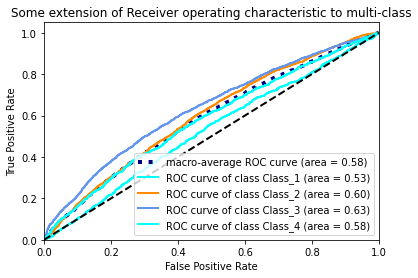

======== CustomCatBoostClassifier - FINISH =======> Take: 21.965330(s)


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CustomCatBoostClassifier(early_stopping_rounds=50, iterations=1000,
                         metric_period=25, task_type='CPU', use_best_model=True,
                         verbose=True)

In [16]:
cb_1.fit(X_train, y_train)

In [18]:
Y_test_pred = df_test[['id']].copy()
Y_test_pred[cb_1.classes_] = cb_1.predict_proba(X_test)

In [19]:
Y_test_pred

,id,Class_1,Class_2,Class_3,Class_4
0,100000,0.083685,0.617525,0.159469,0.139321
1,100001,0.085108,0.701111,0.129966,0.083815
2,100002,0.068850,0.633927,0.177471,0.119752
3,100003,0.082837,0.518562,0.291262,0.107340
4,100004,0.081423,0.600443,0.199162,0.118972
...,...,...,...,...,...
49995,149995,0.099864,0.691247,0.143206,0.065683
49996,149996,0.085364,0.635254,0.132416,0.146967
49997,149997,0.075198,0.531143,0.219520,0.174140
49998,149998,0.077148,0.619936,0.151919,0.150998


In [23]:
Y_test_pred.to_csv('v0.0.1_simple_cb.csv',index=False)